### Instructions

Перший раз запустити код з допомогою кнопки 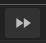

Для повторної роботи з кодом, достатньо перезапустити останній блок коду if __name__ == "__main__": main()

**!!! У таблиці має бути лише одна колонка, в назві якої буде слово Month або Year (не має значення як написано слово - з великої літери, капсом тощо)**
<br>**Всі '-' (пропуски) потрібно замінити на 0**


1. Обрати файл з даними
2. Обрати лист з таблицею
3. Обрати значення, по яким будуть відфільтровані дані
   <br>ВАЖЛИВО: фільтруються лише не числові значення: якщо в таблиці лише колонки з числами, цей пункт буде пропущено
4. Обрати Growth rate / Split:
   * Growth rate -> обрати що зробити з даними по кожній з колонок (sum, average, max)
   *  Split -> обрати колонку, по якій буде зроблено спліт даних
5. Обрати куди зберегти результати:
   * створити новий файл:
     <br>написати назву файлу -> написати назву листа (sheet)
     <br>ФАЙЛ СТВОРЮЄТЬСЯ НА РОБОЧОМУ СТОЛІ 

     
   * зберегти результати в існуючому файлі:
     <br>вибрати файл, в якому буде збережено результати -> написати назву листа (sheet)
     <br>ФАЙЛ, В ЯКОМУ БУДЕ ЗБЕРЕЖЕНО РЕЗУЛЬТАТИ, МАЄ БУТИ ЗАКРИТИМ

### Imports

In [1]:
# pip install pandas
# pip install numpy
# pip install tkinter
# pip install openpyxl
# pip install XlsxWriter

In [2]:
import os
import pandas as pd
import numpy as np
import tkinter as tk
from tkinter import ttk, Tk, Toplevel, Listbox, Button, SINGLE, END, IntVar, Checkbutton, Label, MULTIPLE, Radiobutton, StringVar, messagebox, simpledialog
from tkinter.filedialog import askopenfilename, asksaveasfilename

from openpyxl import Workbook, load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows

### General

In [3]:
operations = ["sum", "mean", "max"]

In [4]:
def get_year_month_cols(df):
    return [col for col in df.columns if 'year' in col or 'month' in col]

def get_numeric_cols(df):
    return [col for col in df.select_dtypes(include='number')]

In [5]:
def select_unique_option(options, title):    
    def on_selected():
        root.destroy()

    root = Toplevel()
    root.title(title)
    root.geometry('600x600')

    selected_option = StringVar(value=options[0])
    for option in options:
         radio_button = tk.Radiobutton(root, text=option, variable=selected_option, value=option)
         radio_button.pack(anchor='w')
    
    select_button = tk.Button(root, text="Select", command=on_selected)
    select_button.pack()
    root.wait_window()

    return selected_option.get()

In [6]:
def ask_string_value(title):
    root = tk.Tk()
    root.withdraw()

    string_value = simpledialog.askstring("Excel Sheet Name", title)
    print(f'string_value = {string_value}')
    if string_value:
        return string_value.strip()
    else:
        messagebox.showerror('Error', 'No sheet name was entered') 
        return None

In [7]:
class ScrollableFrame(ttk.Frame):
    def __init__(self, container, *args, **kwargs):
        super().__init__(container, *args, **kwargs)
        canvas = tk.Canvas(self)
        
        scrollbar = ttk.Scrollbar(self, orient="vertical", command=canvas.yview)
        self.scrollable_frame = ttk.Frame(canvas)

        self.scrollable_frame.bind(
            "<Configure>",
            lambda e: canvas.configure(
                scrollregion=canvas.bbox("all")
            )
        )

        canvas.create_window((0, 0), window=self.scrollable_frame, anchor="nw")
        canvas.configure(yscrollcommand=scrollbar.set)
        canvas.pack(side="left", fill="both", expand=True)
        scrollbar.pack(side="right", fill="y")

### Load a file

In [8]:
def choose_filename():
    Tk().withdraw()

    filename = askopenfilename(
        title="Select an Excel file",
        filetypes=[("Excel files", "*.xlsx *.xls")]
    )
    return filename


def select_sheet(sheet_names):
    top = Toplevel()
    top.title("Select a sheet")
    top.geometry('600x600')
    
    listbox = Listbox(top, selectmode=SINGLE)
    for sheet in sheet_names:
        listbox.insert(END, sheet)
    listbox.pack(padx=10, pady=10)

    selected_sheet = []

    def on_select():
        selection = listbox.curselection()
        if selection:
            selected_sheet.append(sheet_names[selection[0]])
        top.destroy()

    button = Button(top, text="Select", command=on_select)
    button.pack(pady=5)

    top.wait_window(top)
    return selected_sheet[0] if selected_sheet else None


def read_excel_file(filename, sheet_name):
    df = pd.read_excel(filename, sheet_name=sheet_name) 
    df.columns = map(str.lower, df.columns)
    print('Excel file selected')
    return df

In [9]:
def get_dataframe():
    file_path = choose_filename()
    
    if file_path:
        xls = pd.ExcelFile(file_path)
        sheet_name = select_sheet(xls.sheet_names)

        if sheet_name in xls.sheet_names:
            df = read_excel_file(file_path, sheet_name)
            print("DataFrame loaded successfully.")
            return df
        else:
            messagebox.showerror('Error', "Invalid sheet name selected.")
    else:
        messagebox.showerror('Error', "No file selected.") 

### Filter data

In [10]:
def select_filter_values(df):
    def hide_window():
        root.withdraw()
        root.quit()
        
    root = Tk()
    root.title('Select values to filter')
    root.geometry('600x600')

    scrollable_frame = ScrollableFrame(root)
    scrollable_frame.pack(fill="both", expand=True)

    object_cols = df.select_dtypes(include='object').columns.tolist()
    listboxes_dict = {}
    for column in object_cols:
        if object_cols or column in get_year_month_cols(df):
            unique_values = df[column].unique().tolist()
            
            Label(scrollable_frame.scrollable_frame, text=column).pack(pady=5)
            listbox = Listbox(scrollable_frame.scrollable_frame, selectmode=MULTIPLE, exportselection=False)
            listboxes_dict[column] = listbox
            
            for value in sorted(unique_values):
                listbox.insert(tk.END, value)
            listbox.pack(fill=tk.BOTH, expand=True)

    Button(scrollable_frame, text="Apply", command=hide_window).pack()
    root.mainloop()
    return listboxes_dict
    

def get_applied_filters_df(filters):
    applied_filters = {k:v for k, v in filters.items() if v}
    max_length = max(len(v) for v in applied_filters.values())

    for key, val in applied_filters.items():
        if len(val) < max_length:
            nan_count = max_length - len(val)
            val.extend([" "] * nan_count)
    applied_filters_df = pd.DataFrame(applied_filters)
    print(f'applied_filters_df = {applied_filters_df}')
    return applied_filters_df


def filter_dataframe(df): 
    listboxes_dict = select_filter_values(df)
    filters = {}
    filtered_df = df.copy()
    for column, box in listboxes_dict.items():
        selected_values = [box.get(i) for i in box.curselection()]
        if "All" not in selected_values:
            filters[column] = selected_values

    applied_filters_df = get_applied_filters_df(filters)
    
    for col, values in filters.items():
        query_str = ' & '.join([f'`{col}` in {value}' for col, value in filters.items() if value])
        print(query_str)
        filtered_df = df.query(query_str)
        return filtered_df, applied_filters_df
    return 'Something went wrong', applied_filters_df 


### Choose "Growth rate" or "Split"

In [11]:
def select_group_or_split():
    options = ['Growth rate', 'Split']
    title = 'I want to get...'
    selected_option = select_unique_option(options, title)
    return selected_option

### Get growth rate results

In [12]:
def select_aggregations_to_apply(df):
    def hide_window():
        root.withdraw()
        root.quit()
        
    root = Tk()
    root.geometry('600x600')
    
    scrollable_frame = ScrollableFrame(root)
    scrollable_frame.pack(fill="both", expand=True)

    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    cols_to_transform = [col for col in numeric_cols if col not in get_year_month_cols(df)]    

    listboxes_dict = {}
    for column in cols_to_transform:
        Label(scrollable_frame.scrollable_frame, text=column).pack(pady=5)
        listbox = Listbox(scrollable_frame.scrollable_frame, selectmode=MULTIPLE, exportselection=False)
        listboxes_dict[column] = listbox
            
        for value in operations:
            listbox.insert(tk.END, value)
        listbox.pack(fill=tk.BOTH, expand=True)

    Button(scrollable_frame.scrollable_frame, text="Apply", command=hide_window).pack()
    root.mainloop()
    return listboxes_dict


def group_data_monthly(df):
    def apply_aggregations():
        aggregations = {}
        for column, box in listboxes_dict.items():
            selected_values = [box.get(i) for i in box.curselection()]
            aggregations[column] = selected_values

        grouped_df = filtered_df.groupby(get_year_month_cols(df)).agg(aggregations)
        grouped_df.columns = ['{}_{}'.format(col, op) for col, op in grouped_df.columns]
        print('Data has been group successfully')
        return grouped_df.reset_index()

    listboxes_dict = select_aggregations_to_apply(df)
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    filtered_df = df[numeric_cols]

    grouped_monthly_df = apply_aggregations()
    return grouped_monthly_df.round(2)

In [42]:
def get_year_aggregations(df):
    column_aggregations = {}
    for column in df.columns:
        for aggregation in operations:
            if aggregation in column:
                column_aggregations[column] = aggregation
    aggregated_df = df.groupby('year').agg(column_aggregations).reset_index()
    return aggregated_df.round(2)
    

def apply_total_aggs(df, year_col_value):
    totals = pd.DataFrame([{'year': f'{year_col_value}'}])
    for col in df.columns:
        for agg in operations:
            if agg in col:
                if agg == 'mean':
                    totals[col] = df.loc[:, col].mean()
                elif agg == 'sum':
                    totals[col] = df.loc[:, col].sum()
                elif agg == 'max':
                    totals[col] = df.loc[:, col].max()
    return totals.round(2)


def get_growth_percentage(df):
    df_prev_year= df.shift(1)
    year_col = [col for col in df.columns if 'year' in col]
    numeric_cols = [col for col in df.columns if col not in year_col]
    growth_df = (df[numeric_cols] / df_prev_year[numeric_cols]) - 1
    result_df = pd.concat([df[year_col], growth_df], axis=1)
    return result_df.round(2)


def get_year_to_date(df):
    year_col = [col for col in df.columns if 'year' in col][0]  #get only name of col
    month_col = [col for col in df.columns if 'month' in col][0]  #get only name of col

    ytd_dict = {}
    last_year_df = df[df[year_col] == df[year_col].max()]
    ytd_dict['last_year'] = last_year_df[year_col].max()    
    ytd_dict['last_month'] = last_year_df[month_col].max()

    last_year = ytd_dict.get('last_year')
    prev_year = last_year - 1
    
    prev_year_df = df[(df[year_col] == prev_year) & (df[month_col] <= ytd_dict.get('last_month'))]  
    
    ytd_totals = apply_total_aggs(prev_year_df, f'YTD{prev_year}')
    print(f'ytd_totals \\n {ytd_totals}')
    return ytd_totals


def get_ytd_growth_rate(df, ytd_prev_year):
    year_col = [col for col in df.columns if 'year' in col][0]  #get only name of col
    last_year_df = df[df[year_col] == df[year_col].max()]
    print(f'ytd_prev_year = {ytd_prev_year}')
    print(f'last_year_df = {last_year_df}')
    
    result_df = last_year_df[[year_col]].copy() 
    
    for col in last_year_df.columns:
        if col != year_col:
            result_df[col] = last_year_df[col] / ytd_prev_year[col].values[0]
    print(f'last_year_df = {result_df}')
    return result_df


def get_total_data_by_years(df):
    aggregated_df = get_year_aggregations(df)
    percentage_df = get_growth_percentage(aggregated_df)

    total_df = apply_total_aggs(df, 'Total')
    if df.columns.str.contains('month').any():
        ytd_prev_year = get_year_to_date(df)
        total_aggregated_df = pd.concat([aggregated_df, total_df, ytd_prev_year])
        print(f'aggregated_df = {aggregated_df}')
        
        ytd_growth_rate = get_ytd_growth_rate(aggregated_df, ytd_prev_year)
        percentage_df = pd.concat([percentage_df, ytd_growth_rate])
    else:
        total_aggregated_df = pd.concat([aggregated_df, total_df])
    return total_aggregated_df, percentage_df

In [14]:
def get_grouped_data(df):
    grouped_monthly = group_data_monthly(df)
    grouped_yearly, growth_rates = get_total_data_by_years(grouped_monthly)
    return [grouped_yearly, growth_rates, grouped_monthly]

### Split selected column

In [15]:
def rename_cols(df):
    col_names = [name for name in df.index.names]
    for name in df.columns.get_level_values(1):
        col_names.append(name)
    flatten_df = df.reset_index()
    flatten_df.columns = col_names
    return flatten_df

def add_grand_total(df):
    result_df = df.fillna(0)
    value_cols = [col for col in result_df.columns if col not in get_year_month_cols(result_df)]
    result_df['Grand Total'] = result_df[value_cols].sum(axis=1).round(2)
    return result_df

In [16]:
def select_single_column_name(split_column_options):
    def on_selected():
        root.destroy()
        
    root = Toplevel()
    root.geometry('600x600')
    
    selected_col = StringVar(value=split_column_options[0])
    for col in split_column_options:
         radio_button = Radiobutton(root, text=col, variable=selected_col, value=col)
         radio_button.pack(anchor='w')
    
    select_button = tk.Button(root, text="Select", command=on_selected)
    select_button.pack()
    root.wait_window()
    return selected_col.get()

In [17]:
def select_column_to_split(df):
    '''
    Select one object column which will be splitted by numeric column (select_col_to_split_by)
    '''
    split_column_options = [col for col in df.columns if col in df.select_dtypes(include='object')]
    selected_col = select_single_column_name(split_column_options)
    return selected_col

In [18]:
def select_col_to_split_by(df):
    '''
    Select a single numeric column to be split between the object column (select_column_to_split)
    '''
    split_column_options = [col for col in df.select_dtypes(include='number') if col not in get_year_month_cols(df)]
    selected_col = select_single_column_name(split_column_options)
    return selected_col

In [19]:
def group_by_year_month(df):
    split_cols = []
    if len(df.select_dtypes(exclude='number').columns.tolist()) > 0:
        column_to_split = select_column_to_split(df)
        split_cols.append(column_to_split)
        
        value_col_to_split_by = select_col_to_split_by(df)
        split_cols.append(value_col_to_split_by)

    year_month_cols = get_year_month_cols(df)

    cols_to_show = year_month_cols + split_cols
    filtered_df = df[cols_to_show]

    grouped_df = filtered_df.groupby(year_month_cols).sum().reset_index()
    return filtered_df

In [20]:
def make_pivot_monthly(df):  
    year_month_cols = get_year_month_cols(df)
    
    object_cols = df.select_dtypes(include='object').columns.tolist()
    number_cols = df.select_dtypes(include='number').columns.tolist()
    
    value_cols = [col for col in number_cols if col not in year_month_cols]
    group_by_cols = year_month_cols + object_cols

    grouped_df = df.groupby(by=group_by_cols).sum().reset_index()
    pivot_df = grouped_df.pivot_table(values=value_cols, index=year_month_cols, columns=object_cols).fillna(0)
    pivot_df = rename_cols(pivot_df)
    pivot_df = add_grand_total(pivot_df)

    print('Data has been split successfully')
    return pivot_df

In [56]:
def get_pivot_yearly(df):
    def get_totals(df):
        new_df = df.copy().reset_index()
        totals = pd.DataFrame([{'year': 'Total'}])
        for col in new_df.columns:
            totals[col] = new_df.loc[:, col].mean()
        return totals

    pivot_yearly = df.copy()
    month_col = [col for col in df.columns if 'month' in col]
    year_col = [col for col in df.columns if 'year' in col]
    
    if len(month_col) > 0:
        pivot_yearly = df.drop(month_col, axis=1)
        
    pivot_yearly = pivot_yearly.groupby(year_col).sum().reset_index()
    totals = get_totals(pivot_yearly)
    
    total_df = pd.concat([pivot_yearly, totals])
    total_df['Grand Total'] = total_df['Grand Total'].round(2)
    return total_df.round(2)

In [22]:
def get_split_by_years(df):
    split_df = df.copy()  
    
    for col in split_df.columns[1:]:  # except 'year'
        split_df[col] = split_df[col] / split_df['Grand Total']
    return split_df

In [54]:
def get_splitted_data(df):
    grouped_df = group_by_year_month(df)
    pivot_monthly_df = pd.DataFrame()
    
    if df.columns.str.contains('month').any():
        pivot_monthly_df = make_pivot_monthly(grouped_df)

    pivot_yearly_df = get_pivot_yearly(pivot_monthly_df)
    split_df = get_split_by_years(pivot_yearly_df)
   
    return [pivot_yearly_df, split_df, pivot_monthly_df]

### Choose "Create Excel file" or "Save to existing file"

In [24]:
def select_how_to_save_results():
    options = ['Create Excel file', 'Save to existing file']
    title = 'I want to...'
    selected_option = select_unique_option(options, title)
    return selected_option

### Create new Excel file

In [25]:
def ask_file_name():
    title = "Enter file name:"
    file_name = ask_string_value(title) + '.xlsx'
    return file_name

In [26]:
def create_new_excel_file():
    file_name = ask_file_name()
    print(f'name = {file_name}')
    desktop_path = os.path.join(os.path.join(os.environ['USERPROFILE']), 'Desktop')
    print(f'path - {desktop_path}')
    file_path = os.path.join(desktop_path, file_name)
    return file_path

### Write to existing Excel file

In [27]:
def get_file_path():
    root = tk.Tk()
    root.withdraw()

    file_path = askopenfilename(
        defaultextension=".xlsx",
        filetypes=[("Excel files", "*.xlsx"), ("All files", "*.*")],
        title="Select Excel File"
    )

    if not file_path:
        messagebox.showerror('Error', 'No file selected')
    return file_path

In [28]:
def ask_sheet_name():
    title = "Enter sheet name:"
    sheet_name = ask_string_value(title)
    return sheet_name

In [29]:
def write_to_excel(file_path, df_list, sheet_name):
    if os.path.exists(file_path):
        first_row = 1
        wb = load_workbook(file_path)
        if sheet_name in wb.sheetnames:
            sheet = wb[sheet_name]
        else:
            sheet = wb.create_sheet(sheet_name)

        for df in df_list:
            for row_idx, row in enumerate(dataframe_to_rows(df, index=False, header=True), start=first_row):
                for col_idx, value in enumerate(row, start=1):
                    sheet.cell(row=row_idx, column=col_idx, value=value)
            first_row += len(df) + 4

        wb.save(file_path)
    else:
        with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
            first_row = 0
            for df in df_list:
                df.to_excel(writer, sheet_name=sheet_name, index=False, startrow=first_row)
                first_row += len(df) + 4

In [30]:
def manage_excel_sheets(df_list):
    res = select_how_to_save_results()

    file_path = ''
    sheet_name = ''
    if res == 'Create Excel file':
        file_path = create_new_excel_file()
        sheet_name = ask_sheet_name()
    elif res == 'Save to existing file':
        file_path = get_file_path()
        sheet_name = ask_sheet_name()
        
    write_to_excel(file_path, df_list, sheet_name)

### Main function

In [36]:
def main():    
    df = get_dataframe()

    df.replace('-', 0, inplace=True)
    
    if len(df.select_dtypes(include='object').columns.tolist()) > 0:
        filtered_df, applied_filters_df = filter_dataframe(df)
    else:
        filtered_df = df.copy()
        applied_filters_df = pd.DataFrame()

    result_df_list = [applied_filters_df]
    selected_option = select_group_or_split()
    if selected_option == 'Split':
        result_df_list += get_splitted_data(filtered_df)
    elif selected_option == 'Growth rate':
        result_df_list += get_grouped_data(filtered_df)
    else:
        messagebox.showerror("Error", "Something went wrong")

    manage_excel_sheets(result_df_list)
    messagebox.showinfo("Congratulation!", "Data transformed and saved :)") 

In [57]:
if __name__ == "__main__":
    main()

Excel file selected
DataFrame loaded successfully.
obj cols = ['retail', 'type', 'аналітична група', 'subgroup', 'package_type', 'manufacturer', 'brand', 'un_sku_def_brand']
applied_filters_df =   subgroup package_type        brand
0     філе          фас  Nasha Ryaba
`subgroup` in ['філе'] & `package_type` in ['фас'] & `brand` in ['Nasha Ryaba']
Data has been split successfully
total_df = Index(['year', 'Nasha Ryaba Chilled Курка Філе 4 Кг Упаковка Фас 1000G',
       'Nasha Ryaba Chilled Курка Філе 9 Кг Упаковка Фас 1000G',
       'Nasha Ryaba Chilled Курка Філе Butterfly Фас 1000G',
       'Nasha Ryaba Chilled Курка Філе Фас 1000G',
       'Nasha Ryaba Chilled Курка Філе Халяль Фас 1000G',
       'Nasha Ryaba Culinary Курка Філе Sous-Vide Фас 1000G', 'Grand Total',
       'index'],
      dtype='object')
pivot_yearly_df =      year  Nasha Ryaba Chilled Курка Філе 4 Кг Упаковка Фас 1000G  \
0  2018.0                                               0.00        
1  2019.0                  